In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import opendatasets as od
import pandas as pd
import os 
import random
import torch
import glob
from torch.utils.data import random_split
import torchvision.models as models

torch.manual_seed(1)

In [2]:
import torchvision.datasets as datasets

transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

geoguessr_data = os.getcwd() + '/geoguessr_data'

train_path = geoguessr_data+'/train'
test_path = geoguessr_data+'/test'
valid_path = geoguessr_data+'/val'


train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = datasets.ImageFolder(root=valid_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=27, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=27, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=27, shuffle=False)

# Get the class names from the dataset
class_names = train_dataset.classes

In [3]:
print(class_names)

['Brazil', 'France', 'Japan', 'United Kingdom', 'United States']


In [5]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [6]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [7]:
def train(model, train_loader, val_loader, batch_size=27, learning_rate = 0.001, num_epochs=30):
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Cross Entropy Loss and the optimizer will be Adam
    # These two were selected because:
    # Cross Entropy Loss - Penalizes the model more heavily when it makes larger errors, which is desirable for image classification
    # Adam - Converges faster than other optimization algorithms, which is important for large-scale image classification
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    ########################################################################
    # Set up some numpy arrays to store the training/test accuracy
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    print ("Training Started...")
    n = 0 # Iteration number
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_images = 0
        for imgs, labels in iter(train_loader):
            
            if torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            # Forward pass, backward pass, and optimize
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            # Zero the parameter gradients
            optimizer.zero_grad()
            n += 1          
        
        # Get accuracy
        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, val_loader)

        print(("Epoch {}: Train acc: {} |" + "Validation acc: {}").format(epoch, train_acc[epoch], val_acc[epoch]))

        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
            
    epochs = np.arange(1, num_epochs + 1)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    return train_acc, val_acc, epochs

In [8]:
def plot_curve(acc, epochs, curve_name):
  plt.plot(epochs, acc)
  plt.title(curve_name + " Curve (Default Parameters)")
  plt.xlabel("Epochs")
  plt.ylabel(curve_name + " Accuracy")
  plt.show()
  return

In [ ]:
class TransferModel(nn.Module):
    def __init__(self):
        super(TransferModel, self).__init__()
        self.name = "transfer"
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.classifier = nn.Linear(512, 5)
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/michaelhong/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|█████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 61.7MB/s]


Training Started...
Epoch 0: Train acc: 0.5863333333333334 |Validation acc: 0.541
Epoch 1: Train acc: 0.678 |Validation acc: 0.588
Epoch 2: Train acc: 0.7541666666666667 |Validation acc: 0.6375
Epoch 3: Train acc: 0.8056666666666666 |Validation acc: 0.648
Epoch 4: Train acc: 0.852 |Validation acc: 0.656
Epoch 5: Train acc: 0.8898333333333334 |Validation acc: 0.6645
Epoch 6: Train acc: 0.9145 |Validation acc: 0.655
Epoch 7: Train acc: 0.9406666666666667 |Validation acc: 0.6575
Epoch 8: Train acc: 0.9531666666666667 |Validation acc: 0.672
Epoch 9: Train acc: 0.9441666666666667 |Validation acc: 0.6665
Epoch 10: Train acc: 0.9425 |Validation acc: 0.6455
Epoch 11: Train acc: 0.9638333333333333 |Validation acc: 0.6585
Epoch 12: Train acc: 0.9696666666666667 |Validation acc: 0.6525
Epoch 13: Train acc: 0.977 |Validation acc: 0.6725
Epoch 14: Train acc: 0.9785 |Validation acc: 0.647
Epoch 15: Train acc: 0.982 |Validation acc: 0.672
Epoch 16: Train acc: 0.9813333333333333 |Validation acc: 0.667

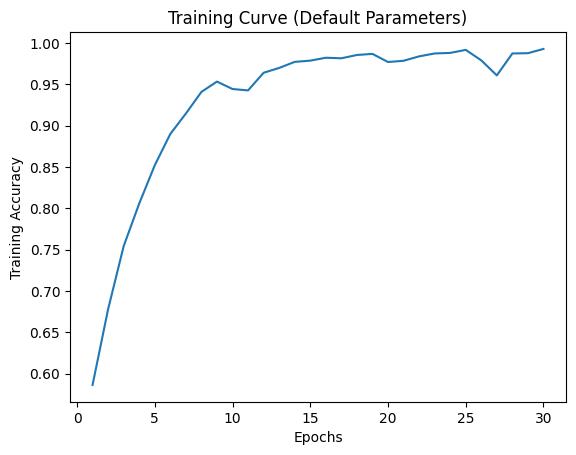

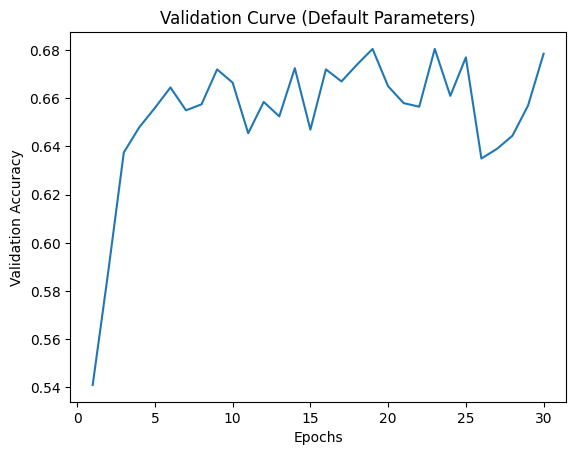

In [ ]:
model_transfer = TransferModel()
if torch.cuda.is_available():
    model_transfer.cuda()
train_acc_transfer, val_acc_transfer, epochs_transfer = train(model_transfer, train_loader, val_loader)
plot_curve(train_acc_transfer, epochs_transfer, "Training")
plot_curve(val_acc_transfer, epochs_transfer, "Validation")

In [24]:
class VGG16TransferModel(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG16TransferModel, self).__init__()
        self.name = "vgg16_transfer"
        vgg = models.vgg16(pretrained=True)
        self.features = nn.Sequential(*list(vgg.features.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Linear(100352, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [25]:
model_vgg = VGG16TransferModel()
if torch.cuda.is_available():
    model_vgg.cuda()
train_acc_vgg, val_acc_vgg, epochs_vgg = train(model_vgg, train_loader, val_loader)
plot_curve(train_acc_vgg, epochs_vgg, "Training")
plot_curve(val_acc_vgg, epochs_vgg, "Validation")

Training Started...
Epoch 0: Train acc: 0.19966666666666666 |Validation acc: 0.2
Epoch 1: Train acc: 0.20666666666666667 |Validation acc: 0.1895
Epoch 2: Train acc: 0.19833333333333333 |Validation acc: 0.2055
Epoch 3: Train acc: 0.19316666666666665 |Validation acc: 0.1945
Epoch 4: Train acc: 0.20266666666666666 |Validation acc: 0.1975
Epoch 5: Train acc: 0.19966666666666666 |Validation acc: 0.2075
Epoch 6: Train acc: 0.20466666666666666 |Validation acc: 0.191
Epoch 7: Train acc: 0.201 |Validation acc: 0.212
Epoch 8: Train acc: 0.19566666666666666 |Validation acc: 0.201


KeyboardInterrupt: ignored

In [26]:
class Inception(nn.Module):
    def __init__(self, num_classes=5):
        super(Inception, self).__init__()
        self.name = "inception"
        inception_v3 = models.inception_v3(pretrained=True)
        self.features = nn.Sequential(
            inception_v3.Conv2d_1a_3x3,
            inception_v3.Conv2d_2a_3x3,
            inception_v3.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            inception_v3.Conv2d_3b_1x1,
            inception_v3.Conv2d_4a_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            inception_v3.Mixed_5b,
            inception_v3.Mixed_5c,
            inception_v3.Mixed_5d,
            inception_v3.Mixed_6a,
            inception_v3.Mixed_6b,
            inception_v3.Mixed_6c,
            inception_v3.Mixed_6d,
            inception_v3.Mixed_6e,
            inception_v3.Mixed_7a,
            inception_v3.Mixed_7b,
            inception_v3.Mixed_7c,
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Started...
Epoch 0: Train acc: 0.5715 |Validation acc: 0.5385
Epoch 1: Train acc: 0.6618333333333334 |Validation acc: 0.595
Epoch 2: Train acc: 0.7425 |Validation acc: 0.6405
Epoch 3: Train acc: 0.7926666666666666 |Validation acc: 0.6755
Epoch 4: Train acc: 0.801 |Validation acc: 0.6455
Epoch 5: Train acc: 0.8365 |Validation acc: 0.6605
Epoch 6: Train acc: 0.8801666666666667 |Validation acc: 0.684
Epoch 7: Train acc: 0.9018333333333334 |Validation acc: 0.675
Epoch 8: Train acc: 0.9106666666666666 |Validation acc: 0.6765
Epoch 9: Train acc: 0.9108333333333334 |Validation acc: 0.669
Epoch 10: Train acc: 0.917 |Validation acc: 0.6675
Epoch 11: Train acc: 0.9493333333333334 |Validation acc: 0.6805
Epoch 12: Train acc: 0.9543333333333334 |Validation acc: 0.698
Epoch 13: Train acc: 0.947 |Validation acc: 0.6725
Epoch 14: Train acc: 0.9773333333333334 |Validation acc: 0.6935
Epoch 15: Train acc: 0.9638333333333333 |Validation acc: 0.6815
Epoch 16: Train acc: 0.9756666666666667 |Valid

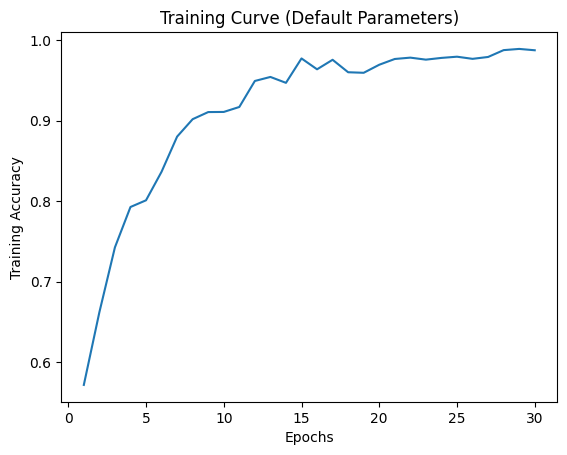

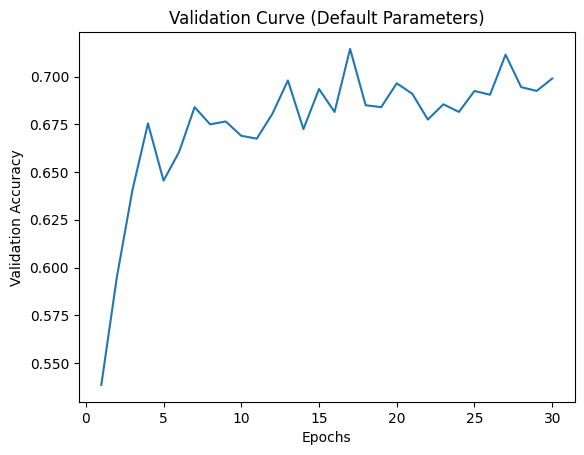

In [28]:
model_inception = Inception()
if torch.cuda.is_available():
    model_inception.cuda()
train_acc_inception, val_acc_inception, epochs_inception = train(model_inception, train_loader, val_loader)
plot_curve(train_acc_inception, epochs_inception, "Training")
plot_curve(val_acc_inception, epochs_inception, "Validation")

In [31]:
class DenseNet(nn.Module):
    def __init__(self, num_classes=5):
        super(DenseNet, self).__init__()
        self.name = "densenet"
        densenet = models.densenet121(pretrained=True)
        self.features = nn.Sequential(*list(densenet.children())[:-1])
        self.classifier1 = nn.Linear(50176, 1024)
        self.classifier2 = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier1(x)
        x = self.classifier2(x)
        return x

In [32]:
model_densenet = DenseNet()
if torch.cuda.is_available():
    model_densenet.cuda()
train_acc_densenet, val_acc_densenet, epochs_densenet = train(model_densenet, train_loader, val_loader)
plot_curve(train_acc_densenet, epochs_densenet, "Training")
plot_curve(val_acc_densenet, epochs_densenet, "Validation")

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Started...
Epoch 0: Train acc: 0.2035 |Validation acc: 0.2045


KeyboardInterrupt: ignored

In [33]:
class MobileNet(nn.Module):
    def __init__(self, num_classes=5):
        super(MobileNet, self).__init__()
        self.name = "mobilenet"
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.features = mobilenet.features
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=1280, out_features=num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # Global Average Pooling
        x = self.classifier(x)
        return x

In [ ]:
model_mobilenet = MobileNet()
if torch.cuda.is_available():
    model_mobilenet.cuda()
train_acc_mobilenet, val_acc_mobilenet, epochs_mobilenet = train(model_mobilenet, train_loader, val_loader)
plot_curve(train_acc_mobilenet, epochs_mobilenet, "Training")
plot_curve(val_acc_mobilenet, epochs_mobilenet, "Validation")

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Started...
Epoch 0: Train acc: 0.6813333333333333 |Validation acc: 0.628
Epoch 1: Train acc: 0.7746666666666666 |Validation acc: 0.6745
Epoch 2: Train acc: 0.8248333333333333 |Validation acc: 0.712
Epoch 3: Train acc: 0.8443333333333334 |Validation acc: 0.714
Epoch 4: Train acc: 0.8681666666666666 |Validation acc: 0.7115
Epoch 5: Train acc: 0.8838333333333334 |Validation acc: 0.7185
Epoch 6: Train acc: 0.8953333333333333 |Validation acc: 0.7215
Epoch 7: Train acc: 0.9221666666666667 |Validation acc: 0.7345
Epoch 8: Train acc: 0.9286666666666666 |Validation acc: 0.731
Epoch 9: Train acc: 0.9251666666666667 |Validation acc: 0.7205
Epoch 10: Train acc: 0.923 |Validation acc: 0.708
Epoch 11: Train acc: 0.9525 |Validation acc: 0.725
Epoch 12: Train acc: 0.9561666666666667 |Validation acc: 0.722
Epoch 13: Train acc: 0.9473333333333334 |Validation acc: 0.7255
Epoch 14: Train acc: 0.9598333333333333 |Validation acc: 0.7215
Epoch 15: Train acc: 0.9625 |Validation acc: 0.7245
Epoch 16: 